In [1]:
import scipy.io as scio
import matplotlib.pyplot as plt

data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')

matrix_data = data['data']

print(f"\nType of 'data':", type(matrix_data))
print(f"Shape of 'data':", matrix_data.shape)


Type of 'data': <class 'numpy.ndarray'>
Shape of 'data': (16, 604700)


In [3]:
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data']
# 提取第一行（第一通道的EEG数据）
first_channel = matrix_data[0, :]
sampled_data = first_channel[:50000:10]
len(sampled_data)

5000

In [4]:
len(sampled_data)

5000

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [08:42<00:00,  2.61s/it]


均方根误差 (RMSE): 7.8922


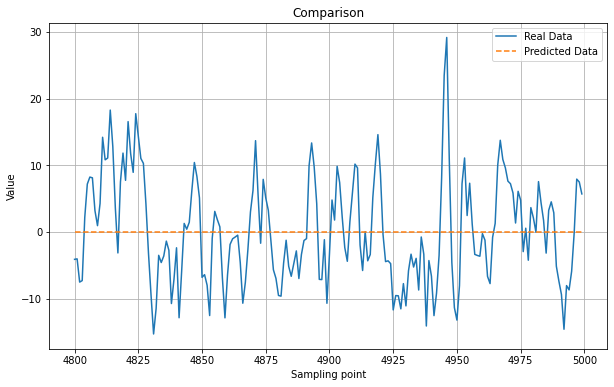

频谱相似度: 0.0271


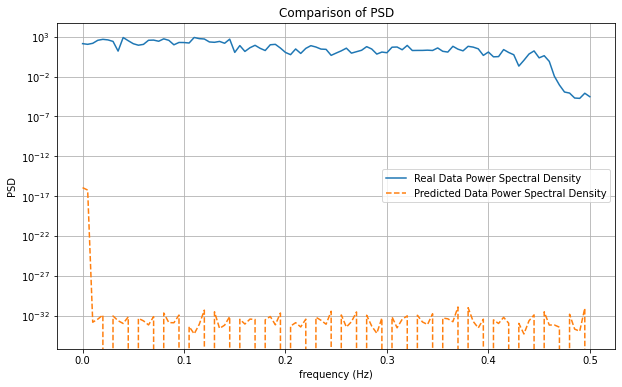

功率谱密度 (PSD) 相似度: 0.0000


In [6]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, LayerNormalization, Dropout, MultiHeadAttention, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# Transformer 层实现
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 自注意力机制
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([inputs, attention_output])  # 残差连接
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # 前馈网络
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Add()([attention_output, ff_output])  # 残差连接
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output)

    return ff_output

# 构建 Transformer 模型
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = BatchNormalization()(x)
    x = Dense(mlp_units, activation="relu")(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长
X = []
y = []

# 构建 Transformer 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 模型参数设置
head_size = 64
num_heads = 4
ff_dim = 128
num_transformer_blocks = 2
mlp_units = 64
dropout = 0.1

# 构建 Transformer 模型
model = build_transformer_model((n_steps, 1), head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout)

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 Transformer 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Training Progress: 100%|█████████████████████████████████████████████████████████████| 500/500 [08:18<00:00,  1.00it/s]


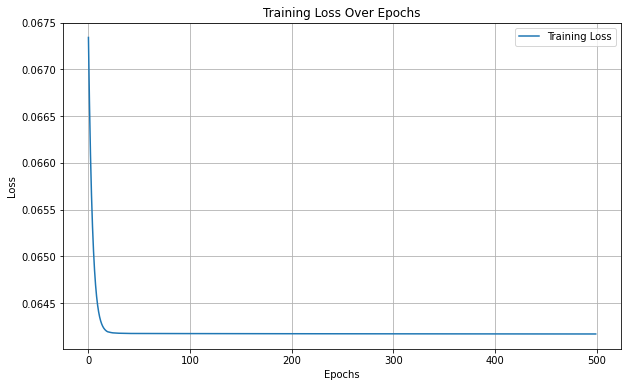

均方根误差 (RMSE): 7.8912


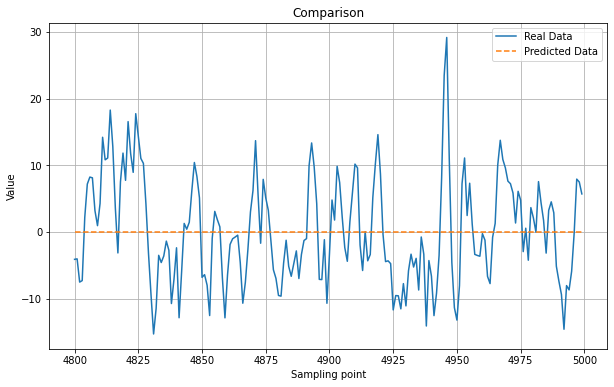

频谱相似度: 0.0271


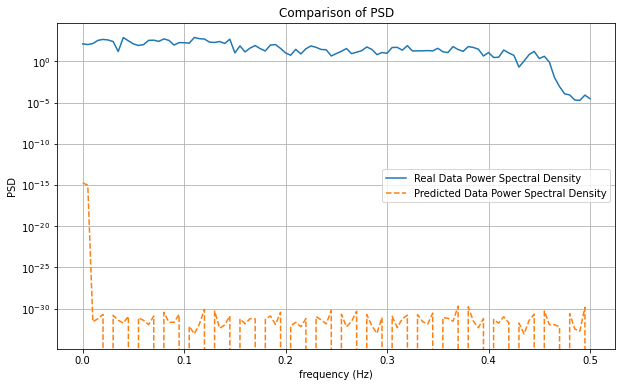

功率谱密度 (PSD) 相似度: 0.0000


In [7]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, LayerNormalization, Dropout, MultiHeadAttention, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# Transformer 层实现
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 自注意力机制
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([inputs, attention_output])  # 残差连接
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # 前馈网络
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Add()([attention_output, ff_output])  # 残差连接
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output)

    return ff_output

# 构建 Transformer 模型
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = BatchNormalization()(x)
    x = Dense(mlp_units, activation="relu")(x)
    x = Dropout(dropout)(x)  # 增加 Dropout 以防止过拟合
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长
X = []
y = []

# 构建 Transformer 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 模型参数设置
head_size = 64
num_heads = 2  # 减少多头注意力的数量
ff_dim = 128
num_transformer_blocks = 1  # 简化模型，减少 Transformer 块数量
mlp_units = 64
dropout = 0.2  # 增加 Dropout

# 构建 Transformer 模型
model = build_transformer_model((n_steps, 1), head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout)

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0, amsgrad=True)  # 调低学习率
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 500  # 增加训练轮数
losses = []  # 用于记录训练损失
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)
        losses.append(logs['loss'])  # 记录每个 epoch 的损失

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 Transformer 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 绘制训练损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


## GRU

Training Progress: 100%|█████████████████████████████████████████████████████████████| 500/500 [20:50<00:00,  2.50s/it]


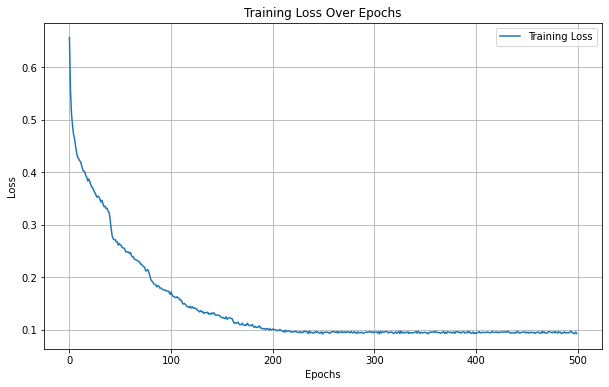

均方根误差 (RMSE): 11.9216


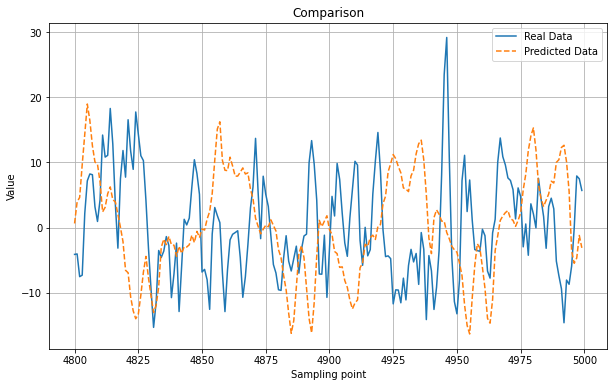

频谱相似度: 0.6595


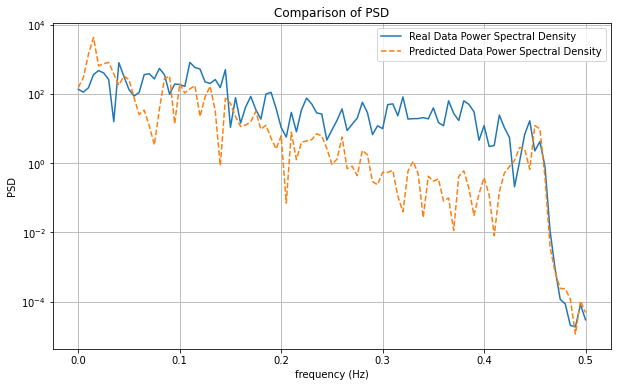

功率谱密度 (PSD) 相似度: 0.3615


In [11]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据预处理改为标准化
scaler = StandardScaler()  # 使用 StandardScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 60  # 增加时间步长
X = []
y = []

# 构建 GRU 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=False)(inputs)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 构建 GRU 模型
model = build_gru_model((n_steps, 1), units=64, dropout=0.1)

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.0005, clipvalue=1.0, amsgrad=True)
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 使用 tqdm 进度条
epochs = 500  # 增加训练轮数
losses = []  # 用于记录训练损失
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)
        losses.append(logs['loss'])  # 记录每个 epoch 的损失

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 绘制训练损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 60 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
148/148 [==============================] - 14s 79ms/step - loss: 0.7613
Epoch 2/200
148/148 [==============================] - 15s 102ms/step - loss: 0.6121
Epoch 3/200
148/148 [==============================] - 15s 103ms/step - loss: 0.5723
Epoch 4/200
148/148 [==============================] - 15s 102ms/step - loss: 0.5489
Epoch 5/200
148/148 [==============================] - 15s 103ms/step - loss: 0.5251
Epoch 6/200
148/148 [==============================] - 15s 102ms/step - loss: 0.5169
Epoch 7/200
148/148 [==============================] - 15s 103ms/step - loss: 0.5116
Epoch 8/200
148/148 [==============================] - 15s 102ms/step - loss: 0.5032
Epoch 9/200
148/148 [==============================] - 15s 103ms/step - loss: 0.4868
Epoch 10/200
148/148 [==============================] - 15s 103ms/step - loss: 0.4880
Epoch 11/200
148/148 [==============================] - 15s 103ms/step - loss: 0.4843
Epoch 12/200
148/148 [==============================] - 15s 103m

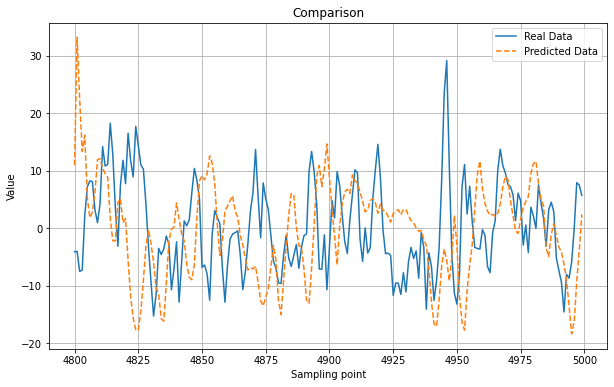

频谱相似度: 0.8183


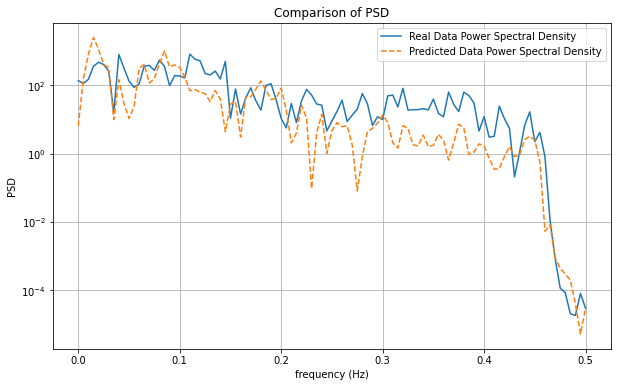

功率谱密度 (PSD) 相似度: 0.4920


In [5]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)  # 第一层 GRU，return_sequences=True
    x = GRU(units)(x)  # 第二层 GRU
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.1 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.2)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 200
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/100
148/148 [==============================] - 13s 73ms/step - loss: 0.7613
Epoch 2/100
148/148 [==============================] - 15s 98ms/step - loss: 0.6121
Epoch 3/100
148/148 [==============================] - 15s 98ms/step - loss: 0.5723
Epoch 4/100
148/148 [==============================] - 14s 97ms/step - loss: 0.5489
Epoch 5/100
148/148 [==============================] - 14s 98ms/step - loss: 0.5251
Epoch 6/100
148/148 [==============================] - 14s 98ms/step - loss: 0.5169
Epoch 7/100
148/148 [==============================] - 15s 98ms/step - loss: 0.5116
Epoch 8/100
148/148 [==============================] - 15s 99ms/step - loss: 0.5032
Epoch 9/100
148/148 [==============================] - 15s 99ms/step - loss: 0.4868
Epoch 10/100
148/148 [==============================] - 15s 99ms/step - loss: 0.4880
Epoch 11/100
148/148 [==============================] - 15s 98ms/step - loss: 0.4843
Epoch 12/100
148/148 [==============================] - 15s 98ms/step - lo

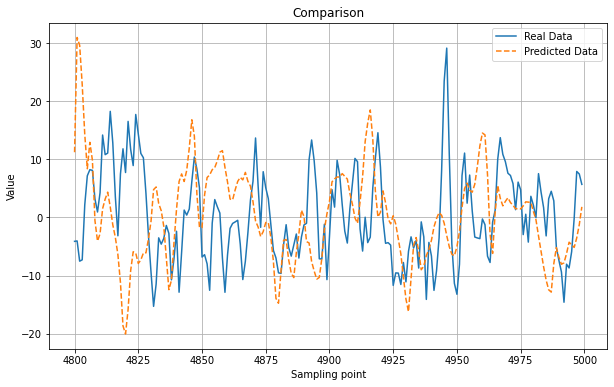

频谱相似度: 0.7557


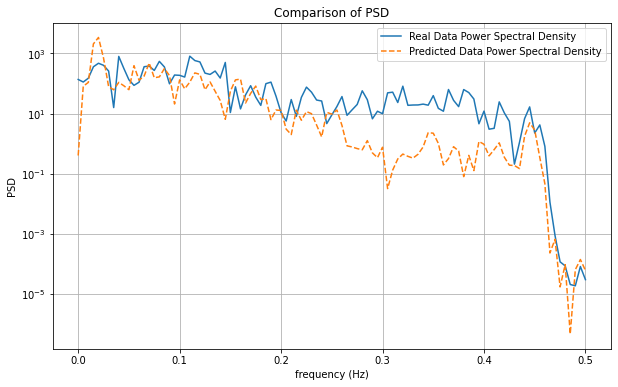

功率谱密度 (PSD) 相似度: 0.4547


In [6]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)  # 第一层 GRU，return_sequences=True
    x = GRU(units)(x)  # 第二层 GRU
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.1 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.2)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 100
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/100
149/149 [==============================] - 8s 36ms/step - loss: 0.8131
Epoch 2/100
149/149 [==============================] - 8s 55ms/step - loss: 0.6342
Epoch 3/100
149/149 [==============================] - 8s 57ms/step - loss: 0.5800
Epoch 4/100
149/149 [==============================] - 8s 56ms/step - loss: 0.5595
Epoch 5/100
149/149 [==============================] - 8s 54ms/step - loss: 0.5435
Epoch 6/100
149/149 [==============================] - 8s 54ms/step - loss: 0.5068
Epoch 7/100
149/149 [==============================] - 8s 54ms/step - loss: 0.4982
Epoch 8/100
149/149 [==============================] - 8s 54ms/step - loss: 0.4457
Epoch 9/100
149/149 [==============================] - 8s 55ms/step - loss: 0.4579
Epoch 10/100
149/149 [==============================] - 8s 54ms/step - loss: 0.4066
Epoch 11/100
149/149 [==============================] - 8s 54ms/step - loss: 0.4012
Epoch 12/100
149/149 [==============================] - 8s 55ms/step - loss: 0.4004
E

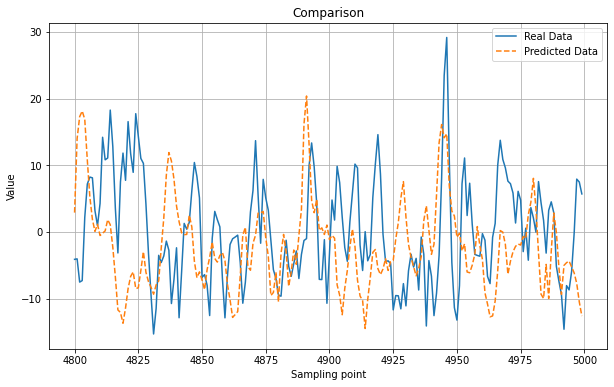

频谱相似度: 0.7329


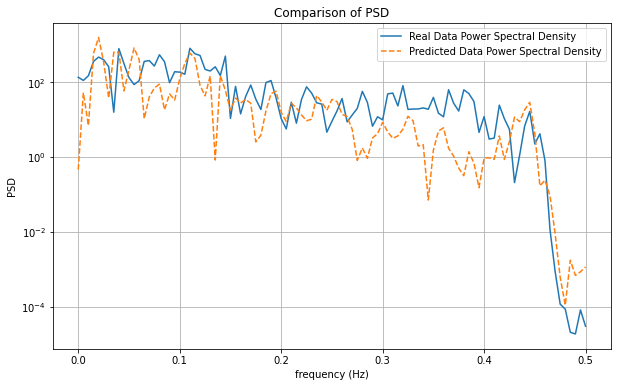

功率谱密度 (PSD) 相似度: 0.6119


In [7]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 50  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)  # 第一层 GRU，return_sequences=True
    x = GRU(units)(x)  # 第二层 GRU
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.1 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.2)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 100
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
149/149 [==============================] - 9s 39ms/step - loss: 0.8131
Epoch 2/200
149/149 [==============================] - 8s 52ms/step - loss: 0.6342
Epoch 3/200
149/149 [==============================] - 8s 57ms/step - loss: 0.5800
Epoch 4/200
149/149 [==============================] - 8s 56ms/step - loss: 0.5595
Epoch 5/200
149/149 [==============================] - 8s 56ms/step - loss: 0.5435
Epoch 6/200
149/149 [==============================] - 8s 56ms/step - loss: 0.5068
Epoch 7/200
149/149 [==============================] - 8s 56ms/step - loss: 0.4982
Epoch 8/200
149/149 [==============================] - 8s 56ms/step - loss: 0.4457
Epoch 9/200
149/149 [==============================] - 8s 56ms/step - loss: 0.4579
Epoch 10/200
149/149 [==============================] - 8s 56ms/step - loss: 0.4066
Epoch 11/200
149/149 [==============================] - 8s 56ms/step - loss: 0.4012
Epoch 12/200
149/149 [==============================] - 8s 56ms/step - loss: 0.4004
E

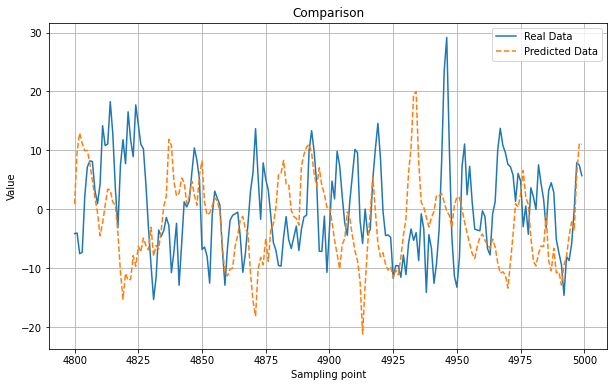

频谱相似度: 0.7579


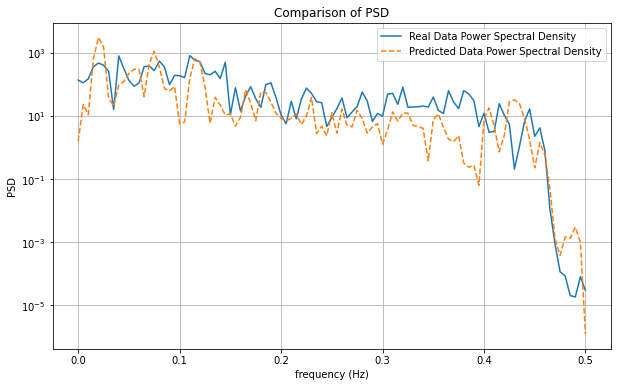

功率谱密度 (PSD) 相似度: 0.5266


In [8]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 50  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)  # 第一层 GRU，return_sequences=True
    x = GRU(units)(x)  # 第二层 GRU
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.1 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.2)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 200
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/300
148/148 [==============================] - 14s 79ms/step - loss: 0.7613
Epoch 2/300
148/148 [==============================] - 15s 102ms/step - loss: 0.6121
Epoch 3/300
148/148 [==============================] - 15s 101ms/step - loss: 0.5723
Epoch 4/300
148/148 [==============================] - 15s 101ms/step - loss: 0.5489
Epoch 5/300
148/148 [==============================] - 15s 101ms/step - loss: 0.5251
Epoch 6/300
148/148 [==============================] - 15s 101ms/step - loss: 0.5169
Epoch 7/300
148/148 [==============================] - 15s 100ms/step - loss: 0.5116
Epoch 8/300
148/148 [==============================] - 15s 100ms/step - loss: 0.5032
Epoch 9/300
148/148 [==============================] - 15s 100ms/step - loss: 0.4868
Epoch 10/300
148/148 [==============================] - 16s 106ms/step - loss: 0.4880
Epoch 11/300
148/148 [==============================] - 15s 100ms/step - loss: 0.4843
Epoch 12/300
148/148 [==============================] - 15s 100m

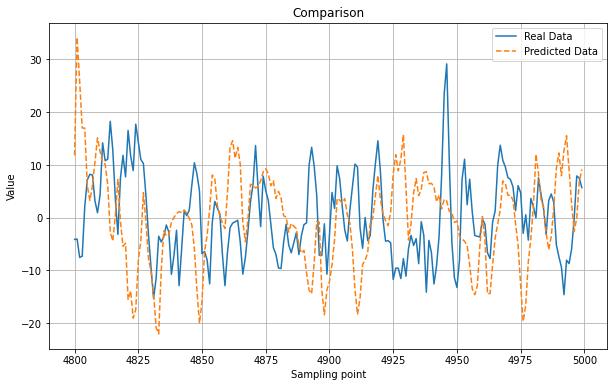

频谱相似度: 0.7458


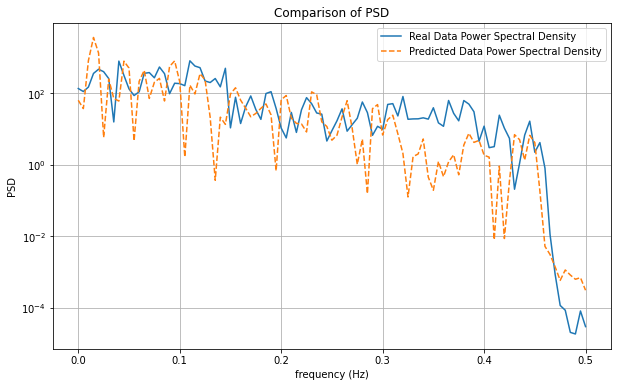

功率谱密度 (PSD) 相似度: 0.4253


In [9]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)  # 第一层 GRU，return_sequences=True
    x = GRU(units)(x)  # 第二层 GRU
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.1 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.2)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 300
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


# epoch 200强制截停比早停机制无上限自动截停效果还好很神奇

## 过拟合泛化能力下降

## mse_loss + 0.5 * spectral_loss

Epoch 1/200
148/148 [==============================] - 15s 79ms/step - loss: 0.9824
Epoch 2/200
148/148 [==============================] - 15s 104ms/step - loss: 0.7737
Epoch 3/200
148/148 [==============================] - 15s 104ms/step - loss: 0.7414
Epoch 4/200
148/148 [==============================] - 16s 109ms/step - loss: 0.7160
Epoch 5/200
148/148 [==============================] - 16s 105ms/step - loss: 0.6761
Epoch 6/200
148/148 [==============================] - 16s 107ms/step - loss: 0.6607
Epoch 7/200
148/148 [==============================] - 16s 105ms/step - loss: 0.6583
Epoch 8/200
148/148 [==============================] - 16s 105ms/step - loss: 0.6456
Epoch 9/200
148/148 [==============================] - 16s 105ms/step - loss: 0.6327
Epoch 10/200
148/148 [==============================] - 16s 105ms/step - loss: 0.6327
Epoch 11/200
148/148 [==============================] - 16s 105ms/step - loss: 0.6230
Epoch 12/200
148/148 [==============================] - 16s 107m

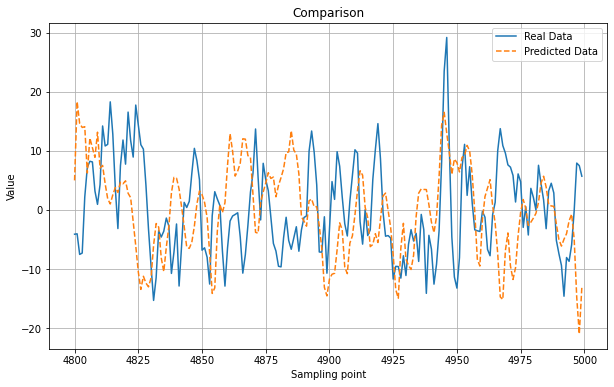

频谱相似度: 0.7771


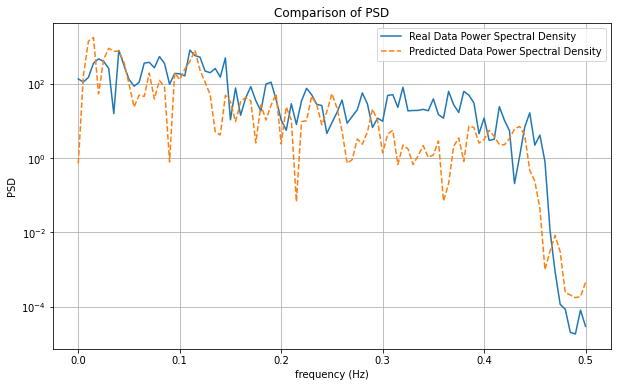

功率谱密度 (PSD) 相似度: 0.5691


In [5]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)  # 第一层 GRU，return_sequences=True
    x = GRU(units)(x)  # 第二层 GRU
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.5 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.2)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 200
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


## 0.5 * mse_loss + spectral_loss

Epoch 1/200
148/148 [==============================] - 14s 76ms/step - loss: 0.8973
Epoch 2/200
148/148 [==============================] - 15s 102ms/step - loss: 0.7135
Epoch 3/200
148/148 [==============================] - 15s 100ms/step - loss: 0.6899
Epoch 4/200
148/148 [==============================] - 15s 100ms/step - loss: 0.6482
Epoch 5/200
148/148 [==============================] - 15s 100ms/step - loss: 0.6367
Epoch 6/200
148/148 [==============================] - 15s 100ms/step - loss: 0.6080
Epoch 7/200
148/148 [==============================] - 15s 99ms/step - loss: 0.6080
Epoch 8/200
148/148 [==============================] - 14s 97ms/step - loss: 0.5879
Epoch 9/200
148/148 [==============================] - 14s 97ms/step - loss: 0.5825
Epoch 10/200
148/148 [==============================] - 14s 97ms/step - loss: 0.5659
Epoch 11/200
148/148 [==============================] - 14s 96ms/step - loss: 0.5691
Epoch 12/200
148/148 [==============================] - 14s 96ms/step

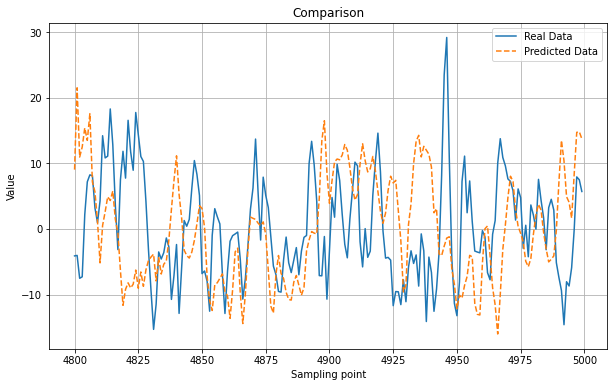

频谱相似度: 0.7607


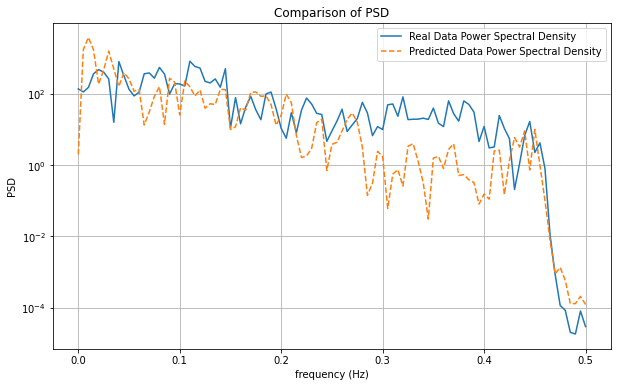

功率谱密度 (PSD) 相似度: 0.3060


In [6]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)  # 第一层 GRU，return_sequences=True
    x = GRU(units)(x)  # 第二层 GRU
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return 0.5 * mse_loss + spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.2)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 200
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


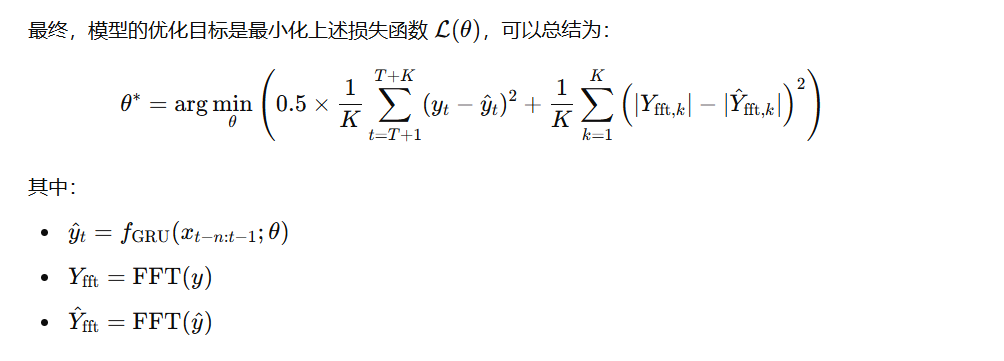

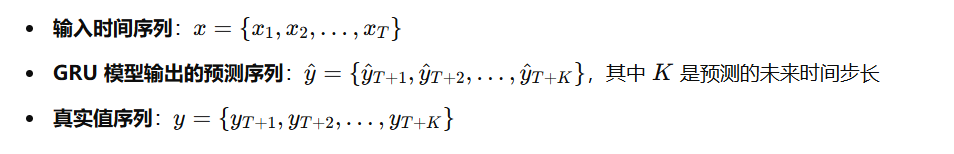

## 改dropout=0.3

Epoch 1/300
148/148 [==============================] - 35s 177ms/step - loss: 0.9012
Epoch 2/300
148/148 [==============================] - 27s 180ms/step - loss: 0.7539
Epoch 3/300
148/148 [==============================] - 27s 182ms/step - loss: 0.7037
Epoch 4/300
148/148 [==============================] - 27s 179ms/step - loss: 0.6718
Epoch 5/300
148/148 [==============================] - 26s 177ms/step - loss: 0.6484
Epoch 6/300
148/148 [==============================] - 26s 173ms/step - loss: 0.6222
Epoch 7/300
148/148 [==============================] - 27s 179ms/step - loss: 0.6212
Epoch 8/300
148/148 [==============================] - 26s 176ms/step - loss: 0.6101
Epoch 9/300
148/148 [==============================] - 28s 187ms/step - loss: 0.6023
Epoch 10/300
148/148 [==============================] - 26s 176ms/step - loss: 0.5815
Epoch 11/300
148/148 [==============================] - 26s 173ms/step - loss: 0.5857
Epoch 12/300
148/148 [==============================] - 25s 170

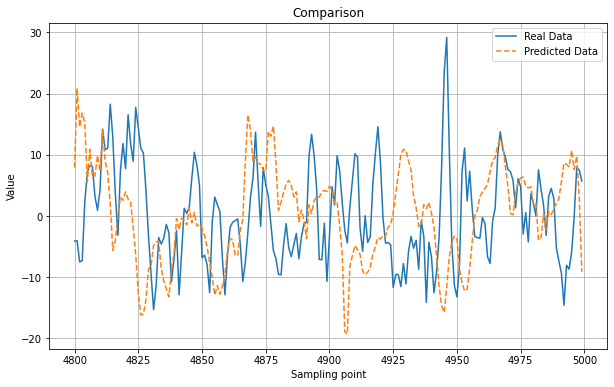

频谱相似度: 0.7268


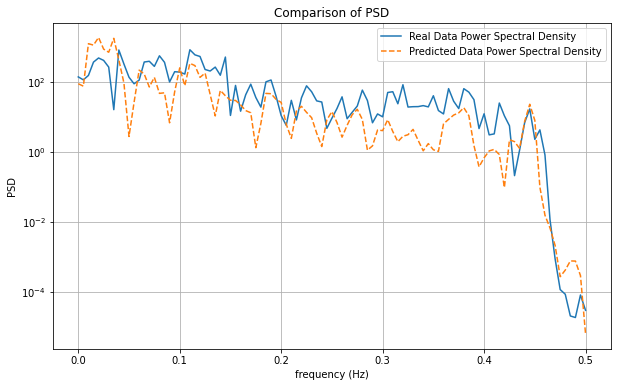

功率谱密度 (PSD) 相似度: 0.4879


In [7]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)  # 第一层 GRU，return_sequences=True
    x = GRU(units)(x)  # 第二层 GRU
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return 0.5 * mse_loss + spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.3)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 300
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


# 三层GRU添加L2正则，优化器Adam

Epoch 1/200
148/148 [==============================] - 27s 159ms/step - loss: 3.9536
Epoch 2/200
148/148 [==============================] - 23s 158ms/step - loss: 2.4923
Epoch 3/200
148/148 [==============================] - 24s 163ms/step - loss: 2.0895
Epoch 4/200
148/148 [==============================] - 25s 166ms/step - loss: 1.8561
Epoch 5/200
148/148 [==============================] - 24s 162ms/step - loss: 1.6450
Epoch 6/200
148/148 [==============================] - 24s 160ms/step - loss: 1.4664
Epoch 7/200
148/148 [==============================] - 24s 164ms/step - loss: 1.3275
Epoch 8/200
148/148 [==============================] - 24s 160ms/step - loss: 1.1957
Epoch 9/200
148/148 [==============================] - 28s 186ms/step - loss: 1.0948
Epoch 10/200
148/148 [==============================] - 24s 160ms/step - loss: 1.0154
Epoch 11/200
148/148 [==============================] - 23s 157ms/step - loss: 0.9376
Epoch 12/200
148/148 [==============================] - 24s 159

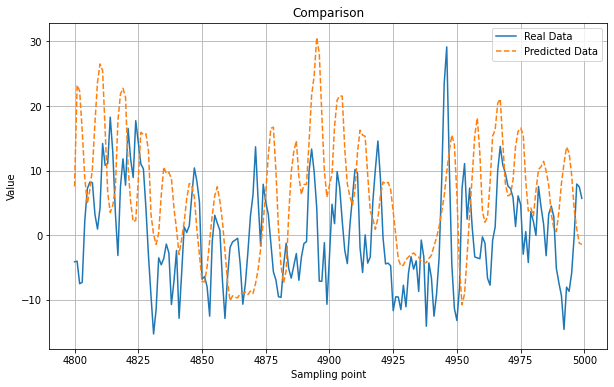

频谱相似度: 0.5921


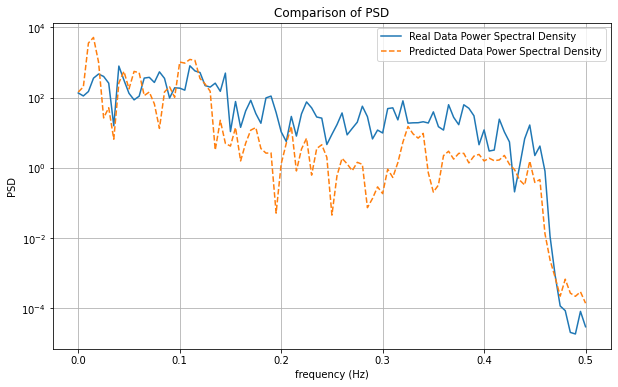

功率谱密度 (PSD) 相似度: 0.4319


In [11]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0, l2_reg=0.01):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True, kernel_regularizer=l2(l2_reg))(inputs)  # 第一层 GRU，带 L2 正则化
    x = GRU(units, return_sequences=True, kernel_regularizer=l2(l2_reg))(x)       # 第二层 GRU，带 L2 正则化
    x = GRU(units, kernel_regularizer=l2(l2_reg))(x)                              # 第三层 GRU，带 L2 正则化
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(x)            # Dense 层，带 L2 正则化
    x = Dropout(dropout)(x)
    x = Dense(1, kernel_regularizer=l2(l2_reg))(x)                                # 输出层，带 L2 正则化
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.1 *spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 200
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


In [9]:
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data']
# 提取第一行（第一通道的EEG数据）
first_channel = matrix_data[0, :]
sampled_data = first_channel[:10000:1]
len(sampled_data)

10000

In [10]:
len(sampled_data)

10000

Epoch 1/200
148/148 [==============================] - 17s 95ms/step - loss: 1.2219
Epoch 2/200
148/148 [==============================] - 15s 103ms/step - loss: 0.4718
Epoch 3/200
148/148 [==============================] - 15s 104ms/step - loss: 0.3238
Epoch 4/200
148/148 [==============================] - 15s 103ms/step - loss: 0.2770
Epoch 5/200
148/148 [==============================] - 15s 104ms/step - loss: 0.2737
Epoch 6/200
148/148 [==============================] - 15s 104ms/step - loss: 0.2315
Epoch 7/200
148/148 [==============================] - 15s 104ms/step - loss: 0.2547
Epoch 8/200
148/148 [==============================] - 16s 106ms/step - loss: 0.2212
Epoch 9/200
148/148 [==============================] - 15s 104ms/step - loss: 0.2117
Epoch 10/200
148/148 [==============================] - 16s 105ms/step - loss: 0.1992
Epoch 11/200
148/148 [==============================] - 15s 105ms/step - loss: 0.1953
Epoch 12/200
148/148 [==============================] - 16s 106m

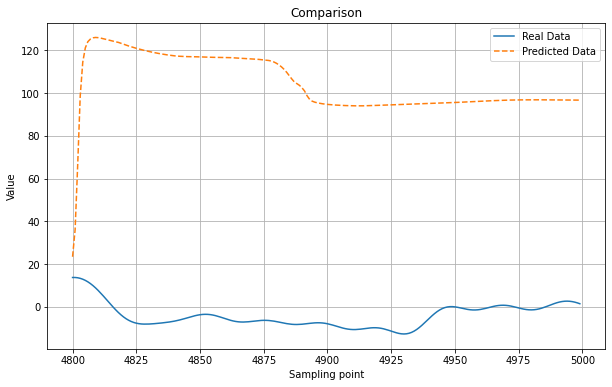

频谱相似度: 0.6788


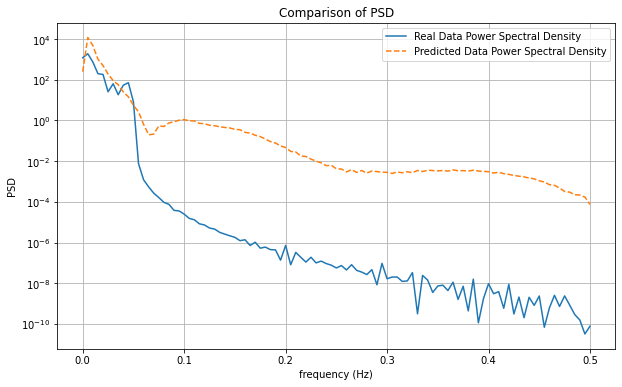

功率谱密度 (PSD) 相似度: 0.8713


In [4]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)  # 第一层 GRU，return_sequences=True
    x = GRU(units)(x)  # 第二层 GRU
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.1 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.2)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 200
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
279/279 [==============================] - 32s 104ms/step - loss: 0.7910
Epoch 2/200
279/279 [==============================] - 29s 104ms/step - loss: 0.3418
Epoch 3/200
279/279 [==============================] - 29s 104ms/step - loss: 0.2600
Epoch 4/200
279/279 [==============================] - 29s 103ms/step - loss: 0.2354
Epoch 5/200
279/279 [==============================] - 29s 104ms/step - loss: 0.2341
Epoch 6/200
279/279 [==============================] - 29s 105ms/step - loss: 0.2071
Epoch 7/200
279/279 [==============================] - 29s 104ms/step - loss: 0.2042
Epoch 8/200
279/279 [==============================] - 29s 103ms/step - loss: 0.1977
Epoch 9/200
279/279 [==============================] - 29s 103ms/step - loss: 0.1805
Epoch 10/200
279/279 [==============================] - 29s 102ms/step - loss: 0.1704
Epoch 11/200
279/279 [==============================] - 28s 102ms/step - loss: 0.1627
Epoch 12/200
279/279 [==============================] - 28s 102

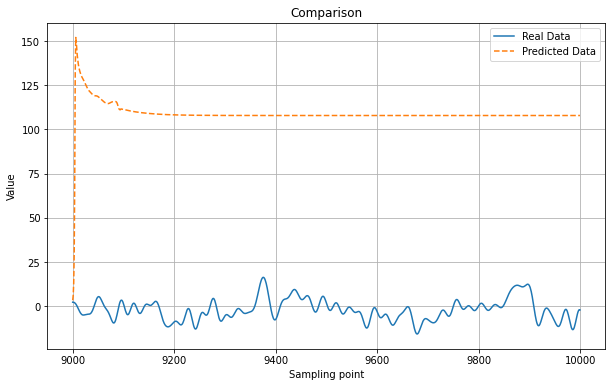

频谱相似度: 0.3615


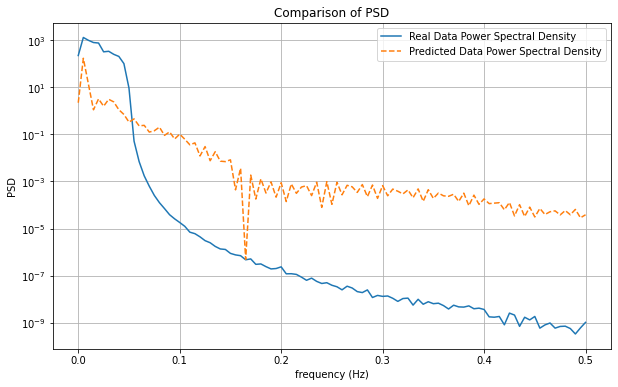

功率谱密度 (PSD) 相似度: 0.6852


In [13]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:10000]
train_data = scaler.fit_transform(sampled_data[:9000].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[9000:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)  # 第一层 GRU，return_sequences=True
    x = GRU(units)(x)  # 第二层 GRU
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.1 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.2)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 200
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(1000):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(9000, 10000), test_data_rescaled, label='Real Data')
plt.plot(range(9000, 10000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
295/295 [==============================] - 31s 96ms/step - loss: 0.7547
Epoch 2/200
295/295 [==============================] - 32s 108ms/step - loss: 0.3463
Epoch 3/200
295/295 [==============================] - 32s 108ms/step - loss: 0.2828
Epoch 4/200
295/295 [==============================] - 32s 109ms/step - loss: 0.2659
Epoch 5/200
295/295 [==============================] - 32s 108ms/step - loss: 0.2275
Epoch 6/200
295/295 [==============================] - 32s 108ms/step - loss: 0.2229
Epoch 7/200
295/295 [==============================] - 32s 108ms/step - loss: 0.2114
Epoch 8/200
295/295 [==============================] - 32s 108ms/step - loss: 0.2020
Epoch 9/200
295/295 [==============================] - 32s 107ms/step - loss: 0.1818
Epoch 10/200
295/295 [==============================] - 32s 107ms/step - loss: 0.1852
Epoch 11/200
295/295 [==============================] - 32s 107ms/step - loss: 0.1775
Epoch 12/200
295/295 [==============================] - 31s 106m

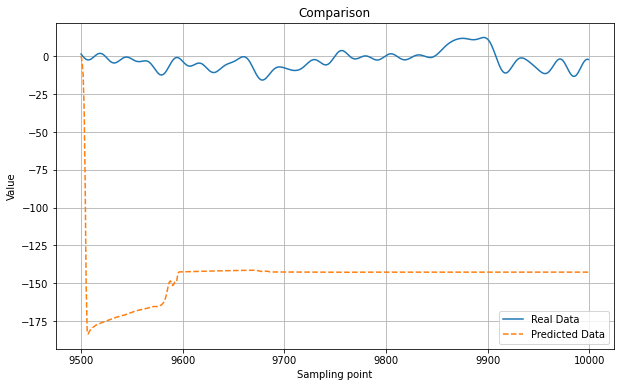

频谱相似度: 0.4882


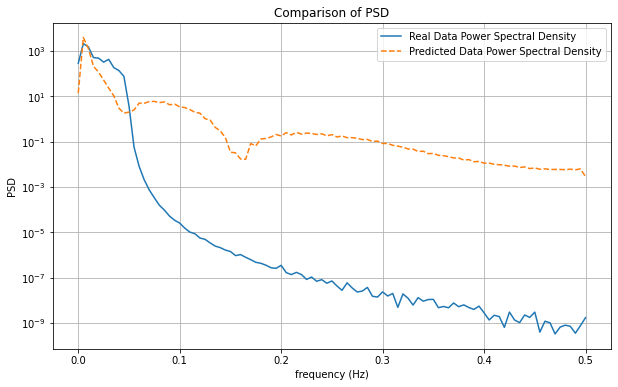

功率谱密度 (PSD) 相似度: 0.9082


In [15]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:10000]
train_data = scaler.fit_transform(sampled_data[:9500].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[9500:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)  # 第一层 GRU，return_sequences=True
    x = GRU(units)(x)  # 第二层 GRU
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.1 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.3)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 200
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(500):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(9500, 10000), test_data_rescaled, label='Real Data')
plt.plot(range(9500, 10000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')
